# Bayesian Approaches to  Testing a Point ("Null") Hypothesis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyjags
import scipy.special as sspecial
import scipy.stats as sstats

import dist_utils
import plot_utils

In [2]:
%load_ext autoreload

%autoreload 2

# Exercise 1

Exploring the null hypothesis, informed priors, and the Haldane prior, analytically.

Utilities

In [3]:
def bern_beta(prior, N, z):
    '''
    Plotting utility that is similar to the `BernBeta.R`
    script from the book.
    '''
    posterior = dist_utils.update_beta(prior, N, z)
    
    x = np.linspace(0, 1, 100)
    fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
    
    # Prior
    ax = axes[0]
    ax.plot(x, prior.pdf(x))
    plot_utils.hdi(dist_utils.hdi(prior), ax=ax)
    ax.set(title='prior')
    
    # Likelihood
    ax = axes[1]
    ax.plot(x, bern_likelihood(N, z, x))
    ax.set(title='likelihood')
    
    # Posterior
    ax = axes[2]
    ax.plot(x, posterior.pdf(x))
    plot_utils.hdi(dist_utils.hdi(posterior), ax=ax)
    ax.set(title='posterior')
    
    fig.tight_layout()

In [4]:
def bern_likelihood(N, z, theta):
    return theta ** z * (1 - theta) ** (N - z)

In [5]:
def prob_data(N, z, beta):
    """
    The probability of `z` heads in `N` flips for a coin with
    bias that equals `beta(a, b)`.
    """
    a, b = beta.args
    return np.exp(sspecial.betaln(z + a, N - z + b) - sspecial.betaln(a, b))

In [6]:
def integrate(dist, interval):
    return dist.cdf(interval[1]) - dist.cdf(interval[0])

Data

In [7]:
N = 24
z = 7
rope = [0.48, 0.52]

## Question A

Probability assuming the null (coin is fair).

In [8]:
theta = 0.5
p_data_null = bern_likelihood(N, z, theta)
p_data_null

5.960464477539063e-08

## Question B

Very narrow prior assuming the coin is fair.

In [9]:
narrow_prior = sstats.beta(2000, 2000)

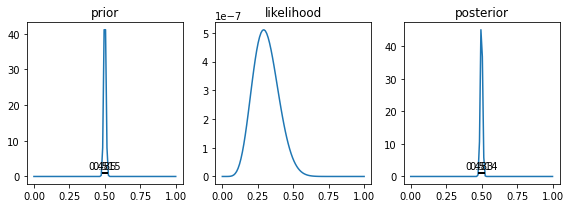

In [10]:
bern_beta(narrow_prior, N, z)

In [11]:
prob_data(N, z, narrow_prior)

6.016980469645256e-08

The narrow beta prior and the exact bias null hypothesis generate similar probabilities for the data. The narrow beta distribution produces a higher probability because it can accept a bias that is different from 0.5 to some (very small) degree, as opposed to the exact bias null hypothesis.

## Question C

The Haldane prior and model comparison to the null (Bayes' factor).

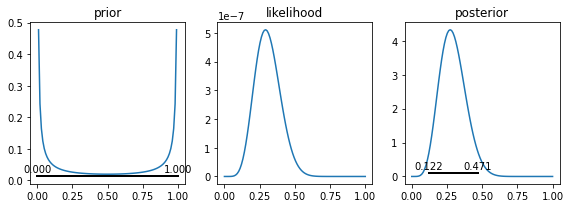

In [12]:
haldane = sstats.beta(0.01, 0.01)
bern_beta(haldane, N, z)

In [13]:
prob_data(N, z, haldane)

2.8667242516097823e-09

In [14]:
prob_data(N, z, haldane) / p_data_null

0.048095651981695665

The Bayes' factor is more than 3 times in favour of the null hypothesis. We will reject the Haldane alternative prior.

## Question D

Estimating the Bayes' factor with the Savage-Dickey method (integral of prior over ROPE divided by integral of posterior over the ROPE).

In [15]:
haldane_posterior = dist_utils.update_beta(haldane, N, z)
integrate(haldane, rope) / integrate(haldane_posterior, rope)

0.04714187767263675

The Bayes' factor is 0.048. The Savage-Dickey estimation produces a very similar value: 0.047.

## Question E

In [16]:
informed_prior = sstats.beta(2, 4)

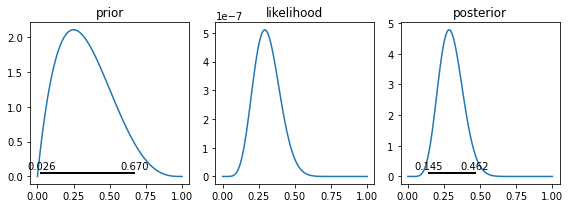

In [17]:
bern_beta(informed_prior, N, z)

In [18]:
prob_data(N, z, informed_prior)

2.2188927736154117e-07

In [19]:
prob_data(N, z, informed_prior) / p_data_null

3.7226843343784863

The Bayes' factor is more than 3 times in favour of the informed alternative prior. We will reject the null hypothesis.

## Question F

In [20]:
informed_posterior = dist_utils.update_beta(informed_prior, N, z)
integrate(informed_prior, rope) / integrate(informed_posterior, rope)

3.610994204842411

The Savage-Dickey estimate is, again, close to the Bayes' factor, as expected.

## Question G

As shown above, the Bayes' factor favours the null compared to the Haldane prior and favours the informed prior compared to the null. HDI comparisons are much more stable: most of the HDI for the Haldane prior and the informed prior overlap (see posterior plots above).

## Question F

Question: "Which approach, model comparison or estimation, seems most informative? Why"

The parameter estimation seems more informative as the output is the posterior distribution as opposed to a decision criteria (Bayes' factor with 3x favour). It's also less sensitive to somewhat arbitrary decisions.

Question: "Within the model-comparison approach, which prior, uninformed Haldane or mildly informed, seems most meaningful? Why?"

The mildly informed prior seems more meaningful. On the other hand, critics might disagree more with the mildly informs than with the Haldane prior.

# Exercise 2

Replicating the example from section 12.2.2.1.

In a study with multiple conditions which model describes the conditoins better: no difference between modes, or different mode for each condition.

In [21]:
CHAINS = 4
ITERATIONS = 20_000

In [22]:
group_means = [0.4, 0.5, 0.51, 0.52]
n_participants_per_group = 20
n_trials_per_participant = 20

In [23]:
df = pd.DataFrame(
    [
        {
            'participant': g_index * n_participants_per_group + i + 1,  # jags counts from 1
            'group': g_index + 1,  # jags counts from 1
            'trials': n_trials_per_participant,
            'correct': np.sum(sstats.bernoulli.rvs(g, size=n_trials_per_participant)),
        }
        for g_index, g in enumerate(group_means)
        for i in range(n_participants_per_group)
    ]
)

In [24]:
df.groupby('group')['correct'].mean()

group
1     8.05
2     9.45
3    10.40
4    11.00
Name: correct, dtype: float64

In [25]:
data = {c: df[c].values for c in df.columns}
data['groups'] = df['group'].unique()

In [26]:
code = """
model {
    for (p in participant) {
        correct[p] ~ dbin(theta[p], trials[p])
        theta[p] ~ dbeta(group_beta_a[group[p]], group_beta_b[group[p]])
    }
    
    for (g in groups) {
        group_beta_a[g] = (equals(m, 1) * omega[g] + equals(m, 2) * omega0) * (kappa[g] - 2) + 1
        group_beta_b[g] = (1 - (equals(m, 1) * omega[g] + equals(m, 2) * omega0)) * (kappa[g] - 2) + 1
        kappa[g] = kappa_minus_two[g] + 2
        kappa_minus_two[g] ~ dgamma(2.618, 0.0809)  # mode 20, sd 20
        omega[g] ~ dbeta(a[m, g], b[m, g])
    }
    omega0 ~ dbeta(a0[m], b0[m])
    m ~ dcat(m_prob)
    
    # Constants for prior and psuedoprior
    aP = 1
    bP = 1
    # a0[m] and b0[m]
    a0[1] = 0.48 * (20 * 20 * 4 - 2) + 1  # psuedoprior
    b0[1] = (1 - 0.48) * (20 * 20 * 4 - 2) + 1  # psuedoprior
    a0[2] = aP  # true
    b0[2] = bP  # true
    # a[m, g] and b[m, g]
    a[1, 1] = aP  # true
    a[1, 2] = aP  # true
    a[1, 3] = aP  # true
    a[1, 4] = aP  # true
    b[1, 1] = bP  # true
    b[1, 2] = bP  # true
    b[1, 3] = bP  # true
    b[1, 4] = bP  # true
    a[2, 1] = 0.40 * (20 * 20 - 2) + 1  # psuedoprior
    a[2, 2] = 0.50 * (20 * 20 - 2) + 1  # psuedoprior
    a[2, 3] = 0.51 * (20 * 20 - 2) + 1  # psuedoprior
    a[2, 4] = 0.52 * (20 * 20 - 2) + 1  # psuedoprior
    b[2, 1] = (1 - 0.40) * (20 * 20 - 2) + 1  # psuedoprior
    b[2, 2] = (1 - 0.50) * (20 * 20 - 2) + 1  # psuedoprior
    b[2, 3] = (1 - 0.51) * (20 * 20 - 2) + 1  # psuedoprior
    b[2, 4] = (1 - 0.52) * (20 * 20 - 2) + 1  # psuedoprior
    # m_prob
    m_prob[1] = 0.5
    m_prob[2] = 0.5
}
"""

In [27]:
model = pyjags.Model(code=code, data=data, chains=CHAINS)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00


In [28]:
trace = model.sample(iterations=ITERATIONS)

sampling: iterations 23892 of 80000, elapsed 0:00:09, remaining 0:00:20
sampling: iterations 37912 of 80000, elapsed 0:00:14, remaining 0:00:15
sampling: iterations 65656 of 80000, elapsed 0:00:24, remaining 0:00:05
sampling: iterations 80000 of 80000, elapsed 0:00:29, remaining 0:00:00
sampling: iterations 80000 of 80000, elapsed 0:00:29, remaining 0:00:00


/home/nagasaki45/code/dbdapy/mcmc_utils.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(marginal_posterior_var / w)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b77999910>,
      dtype=object)

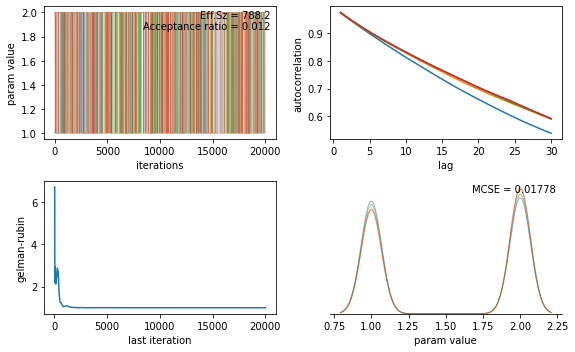

In [29]:
plot_utils.trace_analysis(trace['m'][0])

## Question A

Which model is preferred?

In [30]:
p_model_1 = (trace['m'] == 1).mean()
p_model_2 = (1 - p_model_1)
p_model_1, p_model_2

(0.469125, 0.530875)

In [31]:
p_model_1 / p_model_2

0.8836825994819874

The ratio $\frac{p(M=1 | D)}{p(M=2 | D)}$ is smaller than 1, so model 2 is preffered.

## Question B

Mode when assuming no difference between groups' modes (model 2).

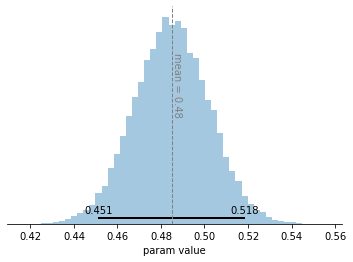

In [32]:
plot_utils.dist(trace['omega0'][0][trace['m'][0] == 2])

Groups' modes and differentes when assuming different modes (model 1).

In [33]:
model_1_trace = trace['omega'].transpose((1, 0, 2))[trace['m'][0] == 1].T

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b77f4ca90>,
      dtype=object)

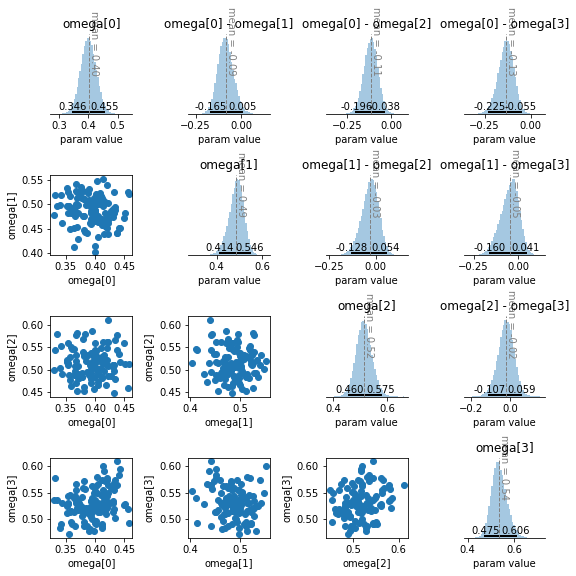

In [34]:
plot_utils.param_comparison(trace, 'omega', comparison=np.arange(4))

The parameters estimate show that the mode of the first group is smaller than the mode of the other (assuming ROPE = [-0.02, 0.02]). The other groups have the same mode. This does not contradict the model comparison decision that concluded that a model with no difference between modes is more credible than a model with differences between modes. Mainly because most of the groups are actually very similar.

## Question C

In [35]:
code = """
model {
    for (p in participant) {
        correct[p] ~ dbin(theta[p], trials[p])
        theta[p] ~ dbeta(group_beta_a[group[p]], group_beta_b[group[p]])
    }
    
    for (g in groups) {
        group_beta_a[g] = (equals(m, 1) * omega[g] + equals(m, 2) * omega0) * (kappa[g] - 2) + 1
        group_beta_b[g] = (1 - (equals(m, 1) * omega[g] + equals(m, 2) * omega0)) * (kappa[g] - 2) + 1
        kappa[g] = kappa_minus_two[g] + 2
        kappa_minus_two[g] ~ dgamma(2.618, 0.0809)  # mode 20, sd 20
    }
    omega[1] ~ dbeta(a[m, 1], b[m, 1])
    omega[2] ~ dbeta(a[m, 2], b[m, 2])
    omega[3] = omega[2]
    omega[4] = omega[2]

    omega0 ~ dbeta(a0[m], b0[m])
    m ~ dcat(m_prob)
    
    # Constants for prior and psuedoprior
    aP = 1
    bP = 1
    # a0[m] and b0[m]
    a0[1] = 0.48 * (20 * 20 * 4 - 2) + 1  # psuedoprior
    b0[1] = (1 - 0.48) * (20 * 20 * 4 -2) + 1  # psuedoprior
    a0[2] = aP  # true
    b0[2] = bP  # true
    # a[m, g] and b[m, g]
    a[1, 1] = aP  # true
    a[1, 2] = aP  # true
    b[1, 1] = bP  # true
    b[1, 2] = bP  # true
    a[2, 1] = 0.40 * (20 * 20 - 2) + 1  # psuedoprior
    a[2, 2] = 0.51 * (20 * 20 * 3 - 2) + 1  # psuedoprior
    b[2, 1] = (1 - 0.40) * (20 * 20 - 2) + 1  # psuedoprior
    b[2, 2] = (1 - 0.51) * (20 * 20 * 3 - 2) + 1  # psuedoprior
    # m_prob
    m_prob[1] = 0.5
    m_prob[2] = 0.5
}
"""

In [36]:
model = pyjags.Model(code=code, data=data, chains=CHAINS)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00


In [37]:
trace = model.sample(iterations=ITERATIONS)

sampling: iterations 23192 of 80000, elapsed 0:00:08, remaining 0:00:19
sampling: iterations 52528 of 80000, elapsed 0:00:18, remaining 0:00:09
sampling: iterations 80000 of 80000, elapsed 0:00:26, remaining 0:00:00
sampling: iterations 80000 of 80000, elapsed 0:00:26, remaining 0:00:00


/home/nagasaki45/code/dbdapy/mcmc_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(marginal_posterior_var / w)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b55385ee0>,
      dtype=object)

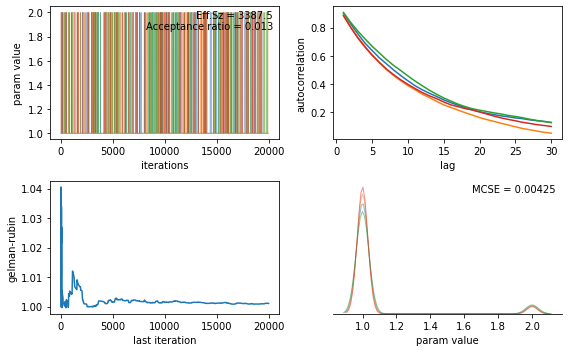

In [38]:
plot_utils.trace_analysis(trace['m'][0])

In [39]:
model_1_trace = trace['omega'].transpose((1, 0, 2))[trace['m'][0] == 1].T

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7b541fa2b0>,
      dtype=object)

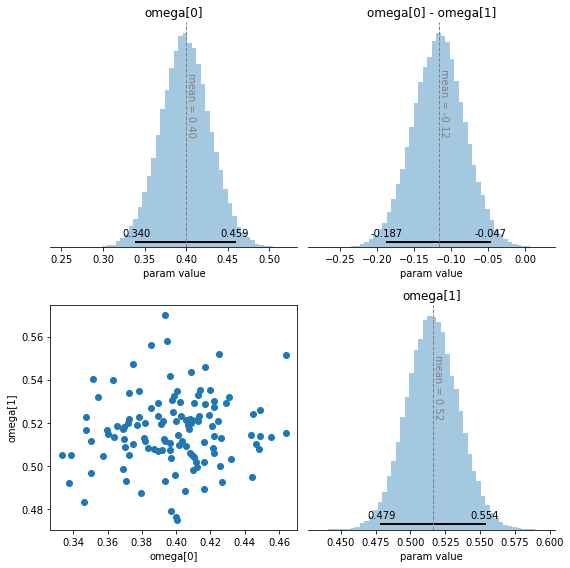

In [40]:
plot_utils.param_comparison(trace, 'omega', comparison=np.arange(2))

This new model (group 1 has one mode and the rest got another mode) again shows a difference between the estimated modes.

In [41]:
p_model_1 = (trace['m'] == 1).mean()
p_model_2 = (1 - p_model_1)
p_model_1, p_model_2

(0.9343875, 0.06561249999999996)

In [42]:
p_model_1 / p_model_2

14.240998285387702

Now model 1 is favourable.

## Question D

The difference is very similar to the differences observed before. In terms of mode estimation, the new model doesn't add much value.

## Question E

Obviously, it looks like the parameter estimation is more informative and more robust. There are cases that I assume that model comparison will be better. Especially when the models have very different structure or rely on different portion of the data.